In [1]:
import cobra
from cobra.io import load_json_model, save_json_model
from cobra import Model, Reaction, Metabolite
import numpy as np
from math import exp
import pandas as pd
from matplotlib import pyplot as plt
from fba_functions import *
import seaborn as sns
from scipy import stats

In [2]:
ipsc_core = load_json_model('../data/gems/iPSC_core.json')
Adata = pd.read_csv('../data/gems/EnzymeActivity.csv')
A_dict = {Adata['Rxn'][i]:Adata['Activity(mmol/hr/g)'][i] for i in range(len(Adata.index))}
def get_grs(biomass, time_pts):
    output = []
    for i in range(len(biomass)-1):
        output.append( np.log(biomass[i+1]/biomass[i]) /(time_pts[i+1]-time_pts[i]) )
    return output  
def avg_cons(cons):
    output = []
    for i in range(len(cons)-1):
        output.append( (cons[i+1]+cons[i])/2 )
    return output
def norm_rates(biomass, cons, time_pts):
    output = []
    for i in range(len(biomass)-1):
        output.append( ((cons[i+1]-cons[i])/(biomass[i]/2+biomass[i+1]/2) )/(time_pts[i+1]-time_pts[i]) )
    return output
def get_pcc(x,y):
    coeff, pv = stats.pearsonr( x, y)
    return coeff

In [3]:
data_low=pd.read_csv('../data/exp_data/CultureData_lowNH4.csv')
data_low=data_low.rename(columns={'Biomass_avg(g/L)':'Biomass_avg','Biomass_std(g/L)':'Biomass_std'})
data_high=pd.read_csv('../data/exp_data/CultureData_highNH4.csv')
data_high=data_high.rename(columns={'Biomass_avg(g/L)':'Biomass_avg','Biomass_std(g/L)':'Biomass_std'})
mets=['Glucose','Gln','Lac','NH4']
Ts= [data_low.Time[i]/2+data_low.Time[i+1]/2 for i in range(len(data_low.Time)-1)]
grs=get_grs(data_low.Biomass_avg, data_low.Time)
approx_low = pd.DataFrame(zip(Ts,grs),columns=['Time','gr'])
for met in mets:
    approx_low[met+'_rate']=norm_rates( data_low.Biomass_avg, data_low[met+'_avg'], data_low.Time)
    approx_low[met+'_conc']=avg_cons( data_low[met+'_avg'] )
Ts=[data_high.Time[i]/2+data_high.Time[i+1]/2 for i in range(len(data_high.Time)-1)]
grs=get_grs(data_high.Biomass_avg, data_high.Time)
approx_high = pd.DataFrame(zip(Ts,grs),columns=['Time','gr'])
for met in mets:
    approx_high[met+'_rate']=norm_rates( data_high.Biomass_avg, data_high[met+'_avg'], data_high.Time)
    approx_high[met+'_conc']=avg_cons( data_high[met+'_avg'] )

# 1. Different [Lac] and [NH4+]

In [4]:
ptot = 0.67366; NGAM = 2.2771;
pred_grs, pred_glc, pred_gln, pred_lac, pred_nh4 = [],[],[],[],[]
for i in [2,3,4,5,7]:
    lac_con = list(approx_low.Lac_conc)[i]
    nh4_con = list(approx_low.NH4_conc)[i]
    AA_lb = inhibit_gln(lac_con, nh4_con, 0.01)
    Glc_lb = nh4_inhibit_glc(lac_con, nh4_con, 0.01)
    OUR_lb = inhibit_our(lac_con, nh4_con, 0.6)
    fluxes = pcfba(ipsc_core, ptot, NGAM, AA_lb, Glc_lb, OUR_lb, A_dict)
    pred_grs.append(fluxes['BIOMASS'])
    pred_glc.append(fluxes['EX_glc__D_e'])
    pred_gln.append(fluxes['EX_gln__L_e'])
    pred_lac.append(fluxes['EX_lac__L_e'])
    pred_nh4.append(fluxes['EX_nh4_e'])

In [5]:
temp_pd = approx_low.iloc[[2,3,4,5,7]]
exp_grs, exp_glc, exp_gln, exp_lac, exp_nh4 = list(temp_pd.gr),list(-1*temp_pd.Glucose_rate),\
list(-1*temp_pd.Gln_rate),list(temp_pd.Lac_rate),list(temp_pd.NH4_rate)
pred_results=[pred_grs, list(-1*np.array(pred_glc)), list(-1*np.array(pred_gln)), pred_lac, pred_nh4]
exp_results=[exp_grs, exp_glc, exp_gln, exp_lac, exp_nh4]
yticks = ['[Lac]='+str(round(list(temp_pd.Lac_conc)[i],2))+'mM\n[NH4+]='+\
           str(round(list(temp_pd.NH4_conc)[i],2))+'mM' for i in range(5) ]
xlabels=['Growth rate (1/hr)','Glucose uptake (mmol/gDW*hr)','Glutamine uptake (mmol/gDW*hr)',
        'Lactate production (mmol/gDW*hr)','NH4+ production (mmol/gDW*hr)']

In [6]:
for i in range(5):
    print(get_pcc(exp_results[i],pred_results[i]))

0.9711195900171697
0.9963869937889406
0.8347107087192336
0.9980678192755781
0.7210739086915986


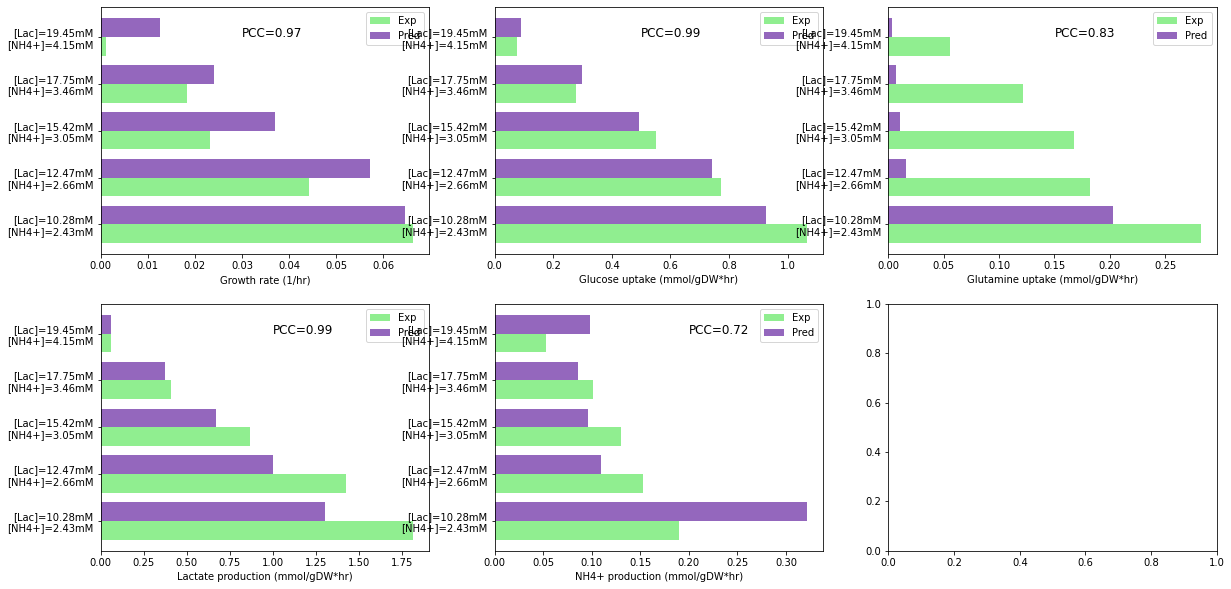

In [7]:
fig, axs = plt.subplots(2,3,figsize=(20,10))
for i in range(5):
    x,y=int(i/3),int(i%3)
    Y_axis = np.arange(1,6)
    axs[x][y].barh(Y_axis - 0.2,exp_results[i],0.4, color='lightgreen',label ='Exp')
    axs[x][y].barh(Y_axis + 0.2,pred_results[i],0.4, color='tab:purple',label ='Pred')
    axs[x][y].set_yticks(Y_axis, yticks);
    axs[x][y].set_xlabel(xlabels[i])
    axs[x][y].legend()
axs[0][0].text(0.03,5,s='PCC=0.97',fontsize=12)
axs[0][1].text(0.5,5,s='PCC=0.99',fontsize=12)
axs[0][2].text(0.15,5,s='PCC=0.83',fontsize=12)
axs[1][0].text(1,5,s='PCC=0.99',fontsize=12)
axs[1][1].text(0.2,5,s='PCC=0.72',fontsize=12)
# plt.savefig('../../Figures/FBA_lowN.svg',format='svg',dpi=150)

In [8]:
ptot = 0.67366; NGAM = 2.2771;
pred_grs, pred_glc, pred_gln, pred_lac, pred_nh4 = [],[],[],[],[]
for i in [1,2,4,6,7]:
    lac_con = list(approx_high.Lac_conc)[i]
    nh4_con = list(approx_high.NH4_conc)[i]
    AA_lb = inhibit_gln(lac_con, nh4_con, 0.01)
    Glc_lb = nh4_inhibit_glc(lac_con, nh4_con, 0.01)
    OUR_lb = inhibit_our(lac_con, nh4_con, 0.6)
    fluxes = pcfba(ipsc_core, ptot, NGAM, AA_lb, Glc_lb, OUR_lb, A_dict)
    pred_grs.append(fluxes['BIOMASS'])
    pred_glc.append(fluxes['EX_glc__D_e'])
    pred_gln.append(fluxes['EX_gln__L_e'])
    pred_lac.append(fluxes['EX_lac__L_e'])
    pred_nh4.append(fluxes['EX_nh4_e'])

In [9]:
temp_pd = approx_high.iloc[[1,2,4,6,7]]
exp_grs, exp_glc, exp_gln, exp_lac, exp_nh4 = list(temp_pd.gr),list(-1*temp_pd.Glucose_rate),\
list(-1*temp_pd.Gln_rate),list(temp_pd.Lac_rate),list(temp_pd.NH4_rate)
pred_results=[pred_grs, list(-1*np.array(pred_glc)), list(-1*np.array(pred_gln)), pred_lac, pred_nh4]
exp_results=[exp_grs, exp_glc, exp_gln, exp_lac, exp_nh4]
yticks = ['[Lac]='+str(round(list(temp_pd.Lac_conc)[i],2))+'mM\n[NH4+]='+\
           str(round(list(temp_pd.NH4_conc)[i],2))+'mM' for i in range(5) ]
xlabels=['Growth rate (1/hr)','Glucose uptake (mmol/gDW*hr)','Glutamine uptake (mmol/gDW*hr)',
        'Lactate production (mmol/gDW*hr)','NH4+ production (mmol/gDW*hr)']

In [10]:
for i in range(5):
    print(get_pcc(exp_results[i],pred_results[i]))

0.8447055769066345
0.9502812917059489
0.7968532632283858
0.906369072372328
0.9459383999718463


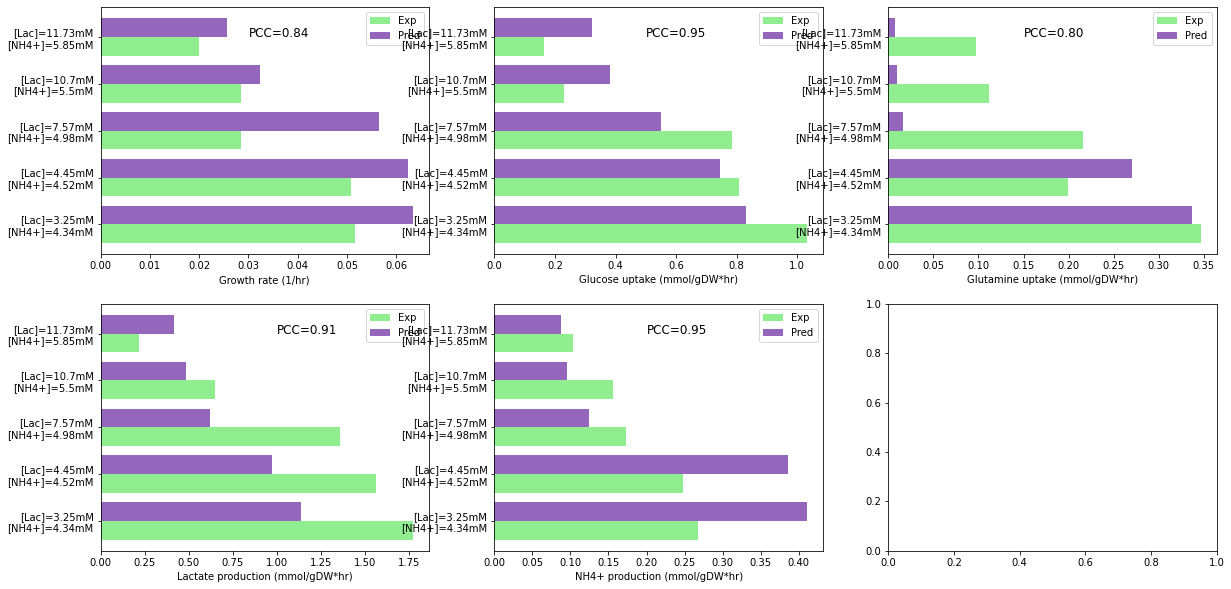

In [12]:
fig, axs = plt.subplots(2,3,figsize=(20,10))
for i in range(5):
    x,y=int(i/3),int(i%3)
    Y_axis = np.arange(1,6)
    axs[x][y].barh(Y_axis - 0.2,exp_results[i],0.4, color='lightgreen',label ='Exp')
    axs[x][y].barh(Y_axis + 0.2,pred_results[i],0.4, color='tab:purple',label ='Pred')
    axs[x][y].set_yticks(Y_axis, yticks);
    axs[x][y].set_xlabel(xlabels[i])
    axs[x][y].legend()
axs[0][0].text(0.03,5,s='PCC=0.84',fontsize=12)
axs[0][1].text(0.5,5,s='PCC=0.95',fontsize=12)
axs[0][2].text(0.15,5,s='PCC=0.80',fontsize=12)
axs[1][0].text(1,5,s='PCC=0.91',fontsize=12)
axs[1][1].text(0.2,5,s='PCC=0.95',fontsize=12)
# plt.savefig('../../Figures/FBA_highN.svg',format='svg',dpi=150)

# 2. Perturbations on NGAM

In [13]:
ptot = 0.67366; NGAM_0 = 2.2771;
NGAM_list = np.linspace(NGAM_0,3.5,num=30)
pred_grs, pred_glc, pred_gln, pred_lac, pred_nh4 = [],[],[],[],[]
for ngam in NGAM_list:
    AA_lb=0.28; Glc_lb=1.07; OUR_lb=2.6;
    fluxes = pcfba(ipsc_core, ptot, ngam, AA_lb, Glc_lb, OUR_lb, A_dict)
    pred_grs.append(fluxes['BIOMASS'])
    pred_glc.append(-1*fluxes['EX_glc__D_e'])
    pred_gln.append(-1*fluxes['EX_gln__L_e'])
    pred_lac.append(fluxes['EX_lac__L_e'])
    pred_nh4.append(fluxes['EX_nh4_e'])

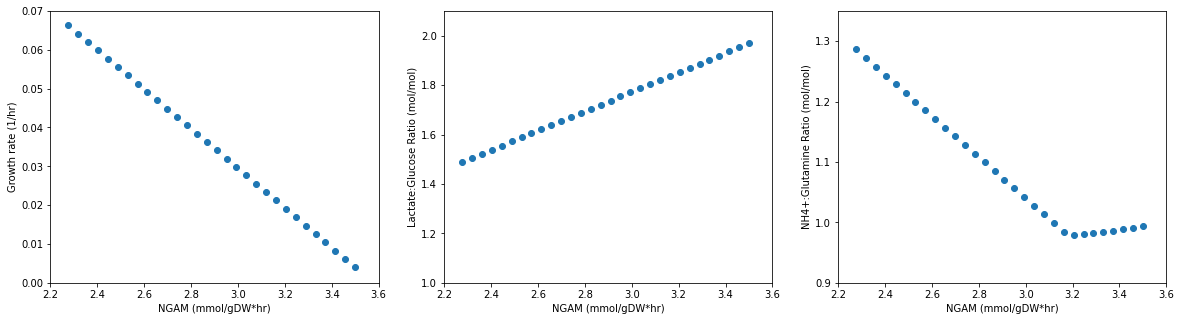

In [14]:
fig,axs=plt.subplots(1,3,figsize=(20,5))
axs[0].scatter(NGAM_list,pred_grs )
axs[1].scatter(NGAM_list,np.array(pred_lac)/np.array(pred_glc) )
axs[2].scatter(NGAM_list,np.array(pred_nh4)/np.array(pred_gln) )
for ax in axs:
    ax.set_xticks(np.arange(2.2,3.7,0.2))
    ax.set_xlabel('NGAM (mmol/gDW*hr)')
axs[0].set_ylabel('Growth rate (1/hr)')
axs[0].set_ylim([0,0.07])
axs[1].set_ylabel('Lactate:Glucose Ratio (mol/mol)')
axs[1].set_ylim([1.0,2.1])
axs[2].set_ylabel('NH4+:Glutamine Ratio (mol/mol)')
axs[2].set_ylim([0.9,1.35])
# plt.savefig('../../Figures/FBA_perturbation_NGAM.svg',format='svg',dpi=150)

In [10]:
ptot = 0.67366; NGAM = 2.2771;
OUR_list = list(np.linspace(0.5,2.0,num=40))+list(np.linspace(1.3,1.4,num=20))
pred_grs, pred_glc, pred_gln, pred_lac, pred_nh4 = [],[],[],[],[]
for our in OUR_list:
    AA_lb=0.28; Glc_lb=1.07;
    fluxes = pcfba(ipsc_core, ptot, NGAM, AA_lb, Glc_lb, our, A_dict)
    pred_grs.append(fluxes['BIOMASS'])
    pred_glc.append(-1*fluxes['EX_glc__D_e'])
    pred_gln.append(-1*fluxes['EX_gln__L_e'])
    pred_lac.append(fluxes['EX_lac__L_e'])
    pred_nh4.append(fluxes['EX_nh4_e'])

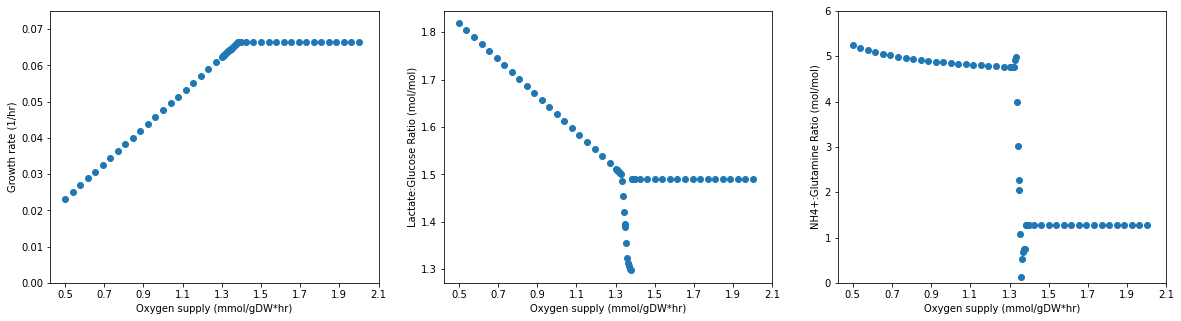

In [24]:
fig,axs=plt.subplots(1,3,figsize=(20,5))
axs[0].scatter(OUR_list,pred_grs )
axs[1].scatter(OUR_list,np.array(pred_lac)/np.array(pred_glc))
axs[2].scatter(OUR_list,np.array(pred_nh4)/np.array(pred_gln))
for ax in axs:
    ax.set_xticks(np.arange(0.5,2.2,0.2))
    ax.set_xlabel('Oxygen supply (mmol/gDW*hr)')
axs[0].set_ylabel('Growth rate (1/hr)')
axs[0].set_ylim([0,0.075])
axs[1].set_ylabel('Lactate:Glucose Ratio (mol/mol)')
# axs[1].set_ylim([1.0,1.9])
axs[2].set_ylabel('NH4+:Glutamine Ratio (mol/mol)')
axs[2].set_ylim([0,6.0])
# plt.savefig('../../Figures/FBA_perturbation_OUR.svg',format='svg',dpi=150)